# Facial Analysis using DeepFace

In [1]:
import itertools
import json
import os
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

## Load Via annotations

In [2]:
images_root = '../images/raw'

via_project_path = os.path.join(images_root, 'via_project_13Sep2022_19h41m.json')

In [6]:
with open(via_project_path, 'r') as f:
    via_project = json.load(f)
    
via_images = via_project['_via_image_id_list']
via_metadata = via_project['_via_img_metadata']
print(f'Dataset contains {len(via_images)} 2x2 images')

Dataset contains 24 2x2 images


In [13]:
via_img = via_images[0]
img_metadata = via_metadata[via_img]

img_path = os.path.join(images_root, img_metadata['filename'])
img_regions = img_metadata['regions']
print(f'Image annotations: {img_path}')
pprint(img_metadata)

Image annotations: ../images/raw\vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png
{'file_attributes': {'height': '512', 'width': '512'},
 'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
 'regions': [{'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 175,
                                   'name': 'rect',
                                   'width': 134,
                                   'x': 66,
                                   'y': 21}},
             {'region_attributes': {'gender': 'Man'},
              'shape_attributes': {'height': 124,
                                   'name': 'rect',
                                   'width': 93,
                                   'x': 338,
                                   'y': 43}},
             {'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 187,
                                   'name': 'rect',
           

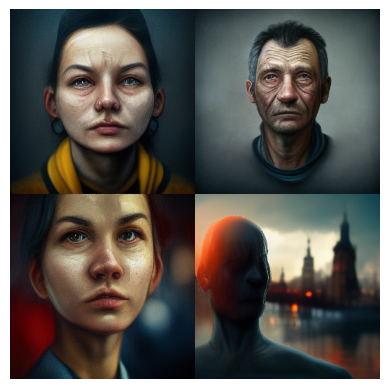

In [14]:
def cv_imshow(image) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
img_2x2 = cv.imread(img_path)
cv_imshow(img_2x2)

In [16]:
def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+width] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

In [17]:
def draw_bbox(
    image: np.ndarray,
    bbox: List[int],
    text: Optional[str] = None,
    color:
    Tuple[int, int, int] = (255,)*3,
    thickness: int = 1,
    fontFace: int = cv.FONT_HERSHEY_SIMPLEX,
    fontScale: float = 0.5
) -> np.ndarray:
    
    cv.rectangle(
        image,
        bbox[:2],
        bbox[2:],
        color=color,
        thickness=thickness
    )
    
    if text:
        (_, h), _ = cv.getTextSize(text, fontFace=fontFace, fontScale=fontScale, thickness=thickness)
        cv.putText(
            image,
            text,
            (bbox[0], bbox[1]+h),
            fontFace=cv.FONT_HERSHEY_SIMPLEX,
            fontScale=fontScale,
            color=color,
            thickness=thickness
    )   
    
    return image

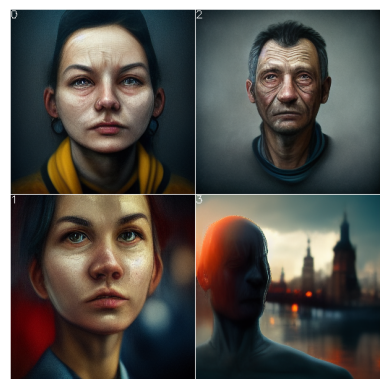

In [19]:
img_2x2 = cv.imread(img_path)

for i, bbox in enumerate(quadrant_bboxes(img_2x2.shape[:2])):
    draw_bbox(img_2x2, bbox, text=f'{i}')

cv_imshow(img_2x2)

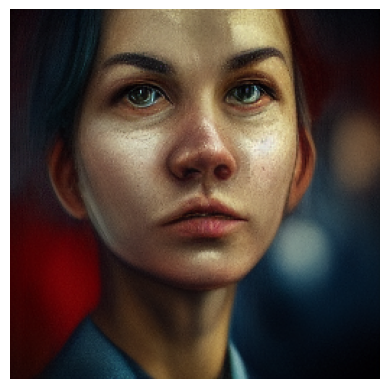

In [31]:
img_sw = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[1])
cv_imshow(img_sw)

In [32]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [45]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

df_actions = [
    'age',
    'gender',
    'race',
    'emotion'
]

def image_predictions(
    image: np.ndarray,
    actions: Tuple[int] = ('age', 'gender', 'race', 'emotion'),
    detector_backend: str = 'mtcnn',
    min_size: int = 20
) -> Optional[dict]:
    
    assert(all(action in df_actions for action in actions))
    assert(detector_backend in df_backends)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=actions,
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, actions)
    except ValueError:
        pass
        
    return predictions

def quadrant_predictions(
    image: np.ndarray,
    **kwargs: dict,
) -> List[Optional[dict]]:
    
    results = []
    for bbox in quadrant_bboxes(image.shape[:2]):
        img_quadrant = crop_bbox(image, bbox)
        predictions = image_predictions(
            img_quadrant,
            **kwargs
        )
        if predictions:
            predictions['bbox'] = [x + y for x, y in zip(predictions['bbox'], bbox[:2]*2)]
        results.append(predictions)
    return results

In [46]:
img_2x2 = cv.imread('2x2.png')
predictions = image_predictions(img_sw, detector_backend='mtcnn')
pprint(predictions)

1/1 [==============================] - 0s 28ms/step
{'age': 25,
 'bbox': [33, 0, 201, 191],
 'emotion': {'angry': 5.0065964460372925,
             'disgust': 0.003950842801714316,
             'fear': 1.5365757048130035,
             'happy': 30.47293722629547,
             'neutral': 5.732032284140587,
             'sad': 2.5591636076569557,
             'surprise': 54.688745737075806},
 'gender': {'Man': 24.55480247735977, 'Woman': 75.44519305229187},
 'race': {'asian': 0.31923078931868076,
          'black': 0.01849999971454963,
          'indian': 0.2657572505995631,
          'latino hispanic': 10.199444741010666,
          'middle eastern': 9.139369428157806,
          'white': 80.05769848823547}}


In [47]:
def project_predictions(
    via_project: dict,
    project_root: str,
    actions: Tuple[int] = ('age', 'gender', 'race', 'emotion'),
    detector_backend: str = 'mtcnn'
) -> List[Tuple[str, List[Optional[dict]]]]:
    predictions = []
    for image_id in tqdm(via_project['_via_image_id_list']):
        filename = via_project['_via_img_metadata'][image_id]['filename']
        image = cv.imread(os.path.join(project_root, filename))
        r = quadrant_predictions(image, actions=actions, detector_backend=detector_backend)
        predictions.append({
            'filename': filename,
            'predictions': r
        })
    return predictions

In [49]:
backend = 'opencv'
predictions = project_predictions(via_project, '../images/raw', detector_backend=backend)
pprint(f'Predictions for {len(predictions)} images')

  0%|                                                                                                            | 0/24 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  4%|████▏                                                                                               | 1/24 [00:04<01:43,  4.52s/it]

1/1 [==============================] - 0s 37ms/step


  8%|████████▎                                                                                           | 2/24 [00:13<02:36,  7.10s/it]

1/1 [==============================] - 0s 64ms/step


 12%|████████████▌                                                                                       | 3/24 [00:23<02:54,  8.33s/it]

1/1 [==============================] - 0s 67ms/step


 17%|████████████████▋                                                                                   | 4/24 [00:33<02:58,  8.95s/it]

1/1 [==============================] - 0s 58ms/step


 21%|████████████████████▊                                                                               | 5/24 [00:40<02:37,  8.31s/it]

1/1 [==============================] - 0s 34ms/step


 25%|█████████████████████████                                                                           | 6/24 [00:49<02:36,  8.69s/it]

1/1 [==============================] - 0s 38ms/step


 29%|█████████████████████████████▏                                                                      | 7/24 [00:59<02:33,  9.02s/it]

1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████████████▎                                                                  | 8/24 [01:06<02:13,  8.36s/it]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████▌                                                              | 9/24 [01:11<01:48,  7.22s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████████████▎                                                         | 10/24 [01:15<01:30,  6.48s/it]

1/1 [==============================] - 0s 33ms/step


 46%|█████████████████████████████████████████████▍                                                     | 11/24 [01:25<01:35,  7.34s/it]

1/1 [==============================] - 0s 35ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 12/24 [01:32<01:27,  7.29s/it]

1/1 [==============================] - 0s 49ms/step


 54%|█████████████████████████████████████████████████████▌                                             | 13/24 [01:39<01:21,  7.37s/it]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████████████████▊                                         | 14/24 [01:49<01:21,  8.17s/it]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████████████████▉                                     | 15/24 [01:52<00:57,  6.43s/it]

1/1 [==============================] - 0s 59ms/step


 67%|██████████████████████████████████████████████████████████████████                                 | 16/24 [02:02<00:59,  7.48s/it]

1/1 [==============================] - 0s 39ms/step


 71%|██████████████████████████████████████████████████████████████████████▏                            | 17/24 [02:07<00:47,  6.75s/it]

1/1 [==============================] - 0s 41ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 18/24 [02:14<00:41,  6.91s/it]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 19/24 [02:25<00:39,  7.97s/it]

1/1 [==============================] - 0s 58ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████▌                | 20/24 [02:35<00:34,  8.58s/it]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 21/24 [02:45<00:27,  9.14s/it]

1/1 [==============================] - 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████▊        | 22/24 [02:54<00:18,  9.18s/it]

1/1 [==============================] - 0s 60ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▉    | 23/24 [03:07<00:10, 10.29s/it]

1/1 [==============================] - 0s 63ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:20<00:00,  8.35s/it]

'Predictions for 24 images'


In [50]:
predictions_path = os.path.join('../images/processed', f'deepface_{backend}.json')

with open(predictions_path, 'w') as fp:
    json.dump(
        predictions,
        fp,
        indent=4,
        sort_keys=True
    )